In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import nibabel as nib
from matplotlib import pyplot as plt
from scipy import stats
import sklearn as sk
from sklearn import tree

from brats21 import utils as bu
from brats21 import postprocessing as post

In [4]:
PATH_TO_SCORES = Path("/sc-scratch/sc-scratch-gbm-radiomics/validation_data/predictions/SubmittedPredictions/TrainerBratsRegions_scores.csv")
PATH_TO_PREDICTIONS = Path("/sc-scratch/sc-scratch-gbm-radiomics/validation_data/predictions/SubmittedPredictions/TrainerBratsRegions")

In [5]:
scores = pd.read_csv(PATH_TO_SCORES)

In [6]:
# scan_id sometimes is loaded as string and sometimes as int...
if scores.scan_id.dtype == int:
    scores.scan_id = scores.scan_id.map(lambda x: f"{x:05}")

In [7]:
scores = scores.iloc[0:219,:]

In [8]:
scores

,scan_id,Dice_ET,Dice_TC,Dice_WT,Hausdorff95_ET,Hausdorff95_TC,Hausdorff95_WT,Sensitivity_ET,Sensitivity_TC,Sensitivity_WT,Specificity_ET,Specificity_TC,Specificity_WT
0,00001,0.835646,0.915608,0.965126,6.557439,10.344080,1.732051,0.771149,0.871779,0.984515,0.999775,0.999836,0.999226
1,00013,0.847054,0.932050,0.928255,2.828427,2.449490,5.099020,0.771399,0.890303,0.880900,0.999706,0.999829,0.999762
2,00015,0.933691,0.965497,0.973979,1.414214,1.414214,1.414214,0.934495,0.966784,0.977534,0.999754,0.999824,0.999248
3,00027,0.803846,0.940124,0.905808,1.732051,2.000000,4.358899,0.867627,0.943881,0.926988,0.999413,0.999752,0.999208
4,00037,0.850693,0.975518,0.957145,2.236068,1.000000,1.414214,0.960658,0.972660,0.964552,0.999834,0.999983,0.999734
...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,01794,0.981466,0.983987,0.976324,1.000000,1.000000,1.000000,0.996817,0.999592,0.976579,0.999965,0.999965,0.999918
215,01795,0.972230,0.984418,0.975920,1.000000,1.000000,1.000000,0.960232,0.996262,0.958514,0.999972,0.999941,0.999955
216,01796,0.984255,0.986723,0.966555,1.000000,1.000000,3.000000,0.970102,0.976217,0.946942,1.000000,0.999999,0.999904
217,01797,1.000000,0.000000,0.837002,0.000000,373.128664,42.391037,1.000000,0.000000,0.726523,1.000000,0.999479,0.999920


In [9]:
scores.loc[:, 'ET %'] = 0
scores.loc[:, 'TC %'] = 0
scores.loc[:, 'WT %'] = 0

for idx, brats_id in enumerate(scores['scan_id']):

    img_path = PATH_TO_PREDICTIONS / f"{brats_id}.nii.gz"
    img = nib.load(img_path).get_fdata()
    
    img_size = img.shape[0] * img.shape[1] * img.shape[2]
    
    scores.loc[idx, 'ET %'] = np.sum(img == 4) / img_size * 100
    scores.loc[idx, 'TC %'] = np.sum(img == 1) / img_size * 100
    scores.loc[idx, 'WT %'] = np.sum(img == 2) / img_size * 100

In [10]:
scores

,scan_id,Dice_ET,Dice_TC,Dice_WT,Hausdorff95_ET,Hausdorff95_TC,Hausdorff95_WT,Sensitivity_ET,Sensitivity_TC,Sensitivity_WT,Specificity_ET,Specificity_TC,Specificity_WT,ET %,TC %,WT %
0,00001,0.835646,0.915608,0.965126,6.557439,10.344080,1.732051,0.771149,0.871779,0.984515,0.999775,0.999836,0.999226,0.254828,0.200717,0.970251
1,00013,0.847054,0.932050,0.928255,2.828427,2.449490,5.099020,0.771399,0.890303,0.880900,0.999706,0.999829,0.999762,0.479794,0.287679,0.467003
2,00015,0.933691,0.965497,0.973979,1.414214,1.414214,1.414214,0.934495,0.966784,0.977534,0.999754,0.999824,0.999248,0.365177,0.123723,1.993033
3,00027,0.803846,0.940124,0.905808,1.732051,2.000000,4.358899,0.867627,0.943881,0.926988,0.999413,0.999752,0.999208,0.233244,0.155242,0.298970
4,00037,0.850693,0.975518,0.957145,2.236068,1.000000,1.414214,0.960658,0.972660,0.964552,0.999834,0.999983,0.999734,0.070228,0.009599,0.447043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,01794,0.981466,0.983987,0.976324,1.000000,1.000000,1.000000,0.996817,0.999592,0.976579,0.999965,0.999965,0.999918,0.105242,0.008065,0.229290
215,01795,0.972230,0.984418,0.975920,1.000000,1.000000,1.000000,0.960232,0.996262,0.958514,0.999972,0.999941,0.999955,0.181026,0.036828,0.523129
216,01796,0.984255,0.986723,0.966555,1.000000,1.000000,3.000000,0.970102,0.976217,0.946942,1.000000,0.999999,0.999904,0.038206,0.001434,0.695161
217,01797,1.000000,0.000000,0.837002,0.000000,373.128664,42.391037,1.000000,0.000000,0.726523,1.000000,0.999479,0.999920,0.000000,0.052128,0.561223


Text(0, 0.5, 'ET Dice')

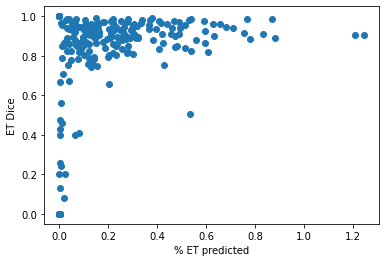

In [11]:
plt.scatter(x=scores['ET %'], y=scores['Dice_ET'])
plt.xlabel('% ET predicted')
plt.ylabel('ET Dice')

In [12]:
stats.spearmanr(scores['ET %'], scores['Dice_ET'])

SpearmanrResult(correlation=0.3000185401867574, pvalue=6.213327523414627e-06)

In [13]:
np.max(scores['ET %'].loc[scores['Dice_ET'] == 0])

0.0035842293906810036

In [14]:
np.sum((scores['ET %'] <= 0.0035842293906810036) & (scores['Dice_ET'] > 0))

13

(0.0, 0.0035842293906810036)

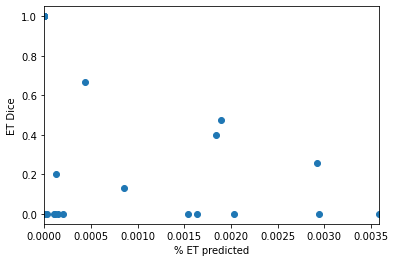

In [15]:
plt.scatter(x=scores['ET %'], y=scores['Dice_ET'])
plt.xlabel('% ET predicted')
plt.ylabel('ET Dice')
plt.xlim(0, np.max(scores['ET %'].loc[scores['Dice_ET'] == 0]))

In [16]:
scores.loc[scores['ET %'] <= 0.0035842293906810036,:]

,scan_id,Dice_ET,Dice_TC,Dice_WT,Hausdorff95_ET,Hausdorff95_TC,Hausdorff95_WT,Sensitivity_ET,Sensitivity_TC,Sensitivity_WT,Specificity_ET,Specificity_TC,Specificity_WT,ET %,TC %,WT %
19,00163,0.000000,0.960243,0.982468,373.128664,1.414214,1.414214,0.000000,0.969395,0.981097,0.999999,0.999884,0.999945,0.000112,0.238206,0.102039
28,00252,1.000000,1.000000,0.881857,0.000000,0.000000,2.236068,1.000000,1.000000,0.885741,1.000000,1.000000,0.999782,0.000000,0.000000,0.178304
138,01718,0.000000,0.911539,0.919985,373.128664,2.828427,3.605551,0.000000,0.865822,0.852028,0.999999,0.999784,0.999997,0.000101,0.570833,0.479772
139,01719,0.000000,0.871719,0.383408,373.128664,2.236068,44.429720,0.000000,0.795697,0.237802,1.000000,0.999969,0.999979,0.000034,0.085058,0.101042
140,01720,0.000000,0.788330,0.943654,373.128664,5.477226,4.123106,0.000000,0.720192,0.907319,0.999998,0.999670,0.999921,0.000202,0.254581,0.210921
144,01724,0.000000,0.944540,0.948302,373.128664,1.732051,1.414214,0.000000,0.918193,0.918662,0.999985,0.999928,0.999933,0.001534,0.257796,0.073096
147,01727,1.000000,0.904632,0.916166,0.000000,4.123106,4.582576,1.000000,0.828328,0.851338,1.000000,0.999978,0.999924,0.000000,0.603674,0.301210
149,01729,0.000000,0.785755,0.960170,373.128664,8.831761,2.236068,0.000000,0.700503,0.936173,0.999980,0.998157,0.999589,0.002027,1.709106,1.027151
151,01731,0.000000,0.959012,0.948582,373.128664,1.414214,2.236068,0.000000,0.945012,0.906422,1.000000,0.999839,0.999948,0.000000,0.603327,0.404659
152,01732,0.000000,0.747421,0.951594,373.128664,14.798649,2.449490,0.000000,0.600098,0.922657,0.999984,0.999917,0.999532,0.001635,0.870733,1.716723


In [17]:
def threshold_ET(row, threshold):
    if row[13] < threshold:
        if row[1] == 0:
            print('Success '+ str(row[0]))
            row[1] = 1
            row[4] = 0
        else:
            print('Failure '+ str(row[0]))
            row[1] = 0
            row[4] = 373.128664
    return(row)

def get_means_threshold(threshold):
    mean_Dice = 0
    mean_Hausdorff = 0
    for sample in scores.values:
        corrected = threshold_ET(sample, threshold)
        mean_Dice += corrected[1]
        mean_Hausdorff += corrected[4]
    mean_Dice = mean_Dice / scores.shape[0]
    mean_Hausdorff = mean_Hausdorff / scores.shape[0]
    return mean_Dice, mean_Hausdorff

In [18]:
get_means_threshold(-10)

(0.8160865251141551, 22.872506488584488)

In [19]:
get_means_threshold(0.001)

Success 00163
Failure 00252
Success 01718
Success 01719
Success 01720
Failure 01727
Success 01731
Failure 01736
Failure 01737
Failure 01739
Failure 01740
Failure 01742
Failure 01743
Success 01744
Failure 01747
Success 01774
Failure 01797


(0.811526287671233, 27.792544287671245)

In [20]:
scores_ETpred = scores.loc[scores['ET %'] > 0,:]

In [21]:
tree_clf = tree.DecisionTreeClassifier(max_depth=2)
tree_clf = tree_clf.fit(scores_ETpred.iloc[:,13:17], scores_ETpred['Hausdorff95_ET']==373.128664)

In [22]:
np.sum(tree_clf.predict(scores_ETpred.iloc[:,13:17]) & (scores_ETpred['Hausdorff95_ET']==373.128664))

8

In [23]:
np.sum(tree_clf.predict(scores_ETpred.iloc[:,13:17]) & (scores_ETpred['Hausdorff95_ET']<373.128664))

1

In [24]:
np.sum(np.invert(tree_clf.predict(scores_ETpred.iloc[:,13:17])) & (scores_ETpred['Hausdorff95_ET']<373.128664))

199

In [25]:
np.sum(np.invert(tree_clf.predict(scores_ETpred.iloc[:,13:17])) & (scores_ETpred['Hausdorff95_ET']==373.128664))

2

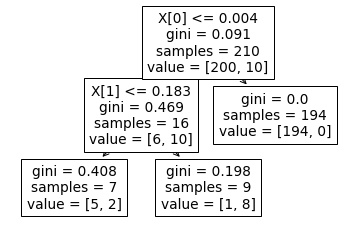

In [26]:
tree.plot_tree(tree_clf);

In [27]:
scores_adj_tree = scores.copy()
preds = tree_clf.predict(scores_adj_tree.iloc[:,13:17])
for idx in range(scores_adj_tree.shape[0]):
    if preds[idx]:
        if scores_adj_tree['ET %'][idx] > 0:
            if scores_adj_tree['Dice_ET'].iloc[idx] == 0:
                print('Success')
                scores_adj_tree['Dice_ET'].iloc[idx] = 1
                scores_adj_tree['Hausdorff95_ET'].iloc[idx] = 0
            else:
                print('Failure')
                scores_adj_tree['Dice_ET'].iloc[idx] = 0
                scores_adj_tree['Hausdorff95_ET'].iloc[idx] = 373.128664
                

Success
Success
Success
Success
Success
Success
Success
Success
Failure


/home/jabareen/miniconda3/envs/brats21/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [28]:
scores_adj_tree

,scan_id,Dice_ET,Dice_TC,Dice_WT,Hausdorff95_ET,Hausdorff95_TC,Hausdorff95_WT,Sensitivity_ET,Sensitivity_TC,Sensitivity_WT,Specificity_ET,Specificity_TC,Specificity_WT,ET %,TC %,WT %
0,00001,0.835646,0.915608,0.965126,6.557439,10.344080,1.732051,0.771149,0.871779,0.984515,0.999775,0.999836,0.999226,0.254828,0.200717,0.970251
1,00013,0.847054,0.932050,0.928255,2.828427,2.449490,5.099020,0.771399,0.890303,0.880900,0.999706,0.999829,0.999762,0.479794,0.287679,0.467003
2,00015,0.933691,0.965497,0.973979,1.414214,1.414214,1.414214,0.934495,0.966784,0.977534,0.999754,0.999824,0.999248,0.365177,0.123723,1.993033
3,00027,0.803846,0.940124,0.905808,1.732051,2.000000,4.358899,0.867627,0.943881,0.926988,0.999413,0.999752,0.999208,0.233244,0.155242,0.298970
4,00037,0.850693,0.975518,0.957145,2.236068,1.000000,1.414214,0.960658,0.972660,0.964552,0.999834,0.999983,0.999734,0.070228,0.009599,0.447043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,01794,0.981466,0.983987,0.976324,1.000000,1.000000,1.000000,0.996817,0.999592,0.976579,0.999965,0.999965,0.999918,0.105242,0.008065,0.229290
215,01795,0.972230,0.984418,0.975920,1.000000,1.000000,1.000000,0.960232,0.996262,0.958514,0.999972,0.999941,0.999955,0.181026,0.036828,0.523129
216,01796,0.984255,0.986723,0.966555,1.000000,1.000000,3.000000,0.970102,0.976217,0.946942,1.000000,0.999999,0.999904,0.038206,0.001434,0.695161
217,01797,1.000000,0.000000,0.837002,0.000000,373.128664,42.391037,1.000000,0.000000,0.726523,1.000000,0.999479,0.999920,0.000000,0.052128,0.561223


In [29]:
np.mean(scores, axis=0)

scan_id                 inf
Dice_ET            0.816087
Dice_TC            0.885116
Dice_WT            0.925715
Hausdorff95_ET    22.872506
Hausdorff95_TC     7.424529
Hausdorff95_WT     3.793220
Sensitivity_ET     0.815478
Sensitivity_TC     0.872930
Sensitivity_WT     0.929037
Specificity_ET     0.999803
Specificity_TC     0.999799
Specificity_WT     0.999364
ET %               0.221743
TC %               0.178246
WT %               0.692153
dtype: float64

In [30]:
np.mean(scores_adj_tree, axis=0)

scan_id                 inf
Dice_ET            0.851451
Dice_TC            0.885116
Dice_WT            0.925715
Hausdorff95_ET    10.914056
Hausdorff95_TC     7.424529
Hausdorff95_WT     3.793220
Sensitivity_ET     0.815478
Sensitivity_TC     0.872930
Sensitivity_WT     0.929037
Specificity_ET     0.999803
Specificity_TC     0.999799
Specificity_WT     0.999364
ET %               0.221743
TC %               0.178246
WT %               0.692153
dtype: float64

In [31]:
np.argwhere(np.asarray(tree_clf.predict(scores_ETpred.iloc[:,13:17]) & (scores_ETpred['Hausdorff95_ET']<373.128664)))

array([[163]])

In [32]:
scores_ETpred.iloc[163,:]

scan_id              01750
Dice_ET           0.255257
Dice_TC           0.873255
Dice_WT            0.94809
Hausdorff95_ET         7.0
Hausdorff95_TC    5.477226
Hausdorff95_WT    3.316625
Sensitivity_ET      0.1463
Sensitivity_TC    0.809677
Sensitivity_WT    0.904904
Specificity_ET         1.0
Specificity_TC    0.999168
Specificity_WT    0.999873
ET %              0.002923
TC %              1.557773
WT %              1.234039
Name: 170, dtype: object

(0.0, 0.0035842293906810036)

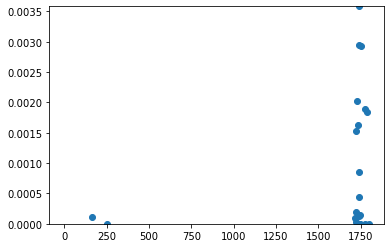

In [33]:
plt.scatter(scores['scan_id'].astype('int'), scores['ET %'])
plt.ylim(0, np.max(scores['ET %'].loc[scores['Dice_ET'] == 0]))

In [34]:
scores['scan_id'][preds]

19     00163
138    01718
140    01720
144    01724
147    01727
149    01729
151    01731
152    01732
158    01738
164    01744
170    01750
Name: scan_id, dtype: object

In [35]:
scores

,scan_id,Dice_ET,Dice_TC,Dice_WT,Hausdorff95_ET,Hausdorff95_TC,Hausdorff95_WT,Sensitivity_ET,Sensitivity_TC,Sensitivity_WT,Specificity_ET,Specificity_TC,Specificity_WT,ET %,TC %,WT %
0,00001,0.835646,0.915608,0.965126,6.557439,10.344080,1.732051,0.771149,0.871779,0.984515,0.999775,0.999836,0.999226,0.254828,0.200717,0.970251
1,00013,0.847054,0.932050,0.928255,2.828427,2.449490,5.099020,0.771399,0.890303,0.880900,0.999706,0.999829,0.999762,0.479794,0.287679,0.467003
2,00015,0.933691,0.965497,0.973979,1.414214,1.414214,1.414214,0.934495,0.966784,0.977534,0.999754,0.999824,0.999248,0.365177,0.123723,1.993033
3,00027,0.803846,0.940124,0.905808,1.732051,2.000000,4.358899,0.867627,0.943881,0.926988,0.999413,0.999752,0.999208,0.233244,0.155242,0.298970
4,00037,0.850693,0.975518,0.957145,2.236068,1.000000,1.414214,0.960658,0.972660,0.964552,0.999834,0.999983,0.999734,0.070228,0.009599,0.447043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,01794,0.981466,0.983987,0.976324,1.000000,1.000000,1.000000,0.996817,0.999592,0.976579,0.999965,0.999965,0.999918,0.105242,0.008065,0.229290
215,01795,0.972230,0.984418,0.975920,1.000000,1.000000,1.000000,0.960232,0.996262,0.958514,0.999972,0.999941,0.999955,0.181026,0.036828,0.523129
216,01796,0.984255,0.986723,0.966555,1.000000,1.000000,3.000000,0.970102,0.976217,0.946942,1.000000,0.999999,0.999904,0.038206,0.001434,0.695161
217,01797,1.000000,0.000000,0.837002,0.000000,373.128664,42.391037,1.000000,0.000000,0.726523,1.000000,0.999479,0.999920,0.000000,0.052128,0.561223


## Postprocessing based on softmax prediction with softmax and decision tree prediction

In [36]:
PREDICTION_WITH_SOFTMAX_PATH = Path("/sc-scratch/sc-scratch-gbm-radiomics/validation_data/predictions/NewPredictions/TrainerBratsRegions")
OUTPUT_DIR = Path("/sc-scratch/sc-scratch-gbm-radiomics/validation_data/predictions/NewPredictions/TrainerBratsRegionsPostprocessed")

In [37]:
# Predict wheather the result hausdorff distance is going to be >370
preds = tree_clf.predict(scores_adj_tree.iloc[:,13:17])

In [38]:
# Supressing labels
# Label 1 => Edema
# Label 2 => Tumor core
# Label 3 => Enhancing tumor

label = 3

post.surpress_labels(preds, PREDICTION_WITH_SOFTMAX_PATH, OUTPUT_DIR, label)

219it [00:15, 14.18it/s]


## Sanity check transformation

In [47]:
print("Image IDs of images that have been changed: \n\n", scores_adj_tree.scan_id[preds], sep="")

Image IDs of images that have been changed: 

19     00163
138    01718
140    01720
144    01724
147    01727
149    01729
151    01731
152    01732
158    01738
164    01744
170    01750
Name: scan_id, dtype: object


In [48]:
img_id = "00163"

In [49]:
# Load prediction masks
old = PREDICTION_WITH_SOFTMAX_PATH / f"{img_id}.nii.gz"
new = OUTPUT_DIR / f"{img_id}.nii.gz"

old = nib.load(old).get_fdata()
new = nib.load(new).get_fdata()

In [50]:
print("Previous unqiue labels: \t", np.unique(old))
print("Processed unqiue labels: \t", np.unique(new))

Previous unqiue labels: 	 [0. 1. 2. 3.]
Processed unqiue labels: 	 [0. 1. 2.]


In [51]:
previous_label_idx = np.where(old == label)

print("Postprocessing has changed label to: \n", new[previous_label_idx])
print("\nAt this positions:")
print("\t H:", previous_label_idx[0])
print("\t W:", previous_label_idx[1])
print("\t D:", previous_label_idx[2])

Postprocessing has changed label to: 
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]

At this positions:
	 H: [102 107 107 108 117 117 117 117 117 117]
	 W: [143 139 140 139 137 140 141 142 143 144]
	 D: [104 120 120 120 115 114 113 113 112 112]


In [52]:
hs = previous_label_idx[0][0] - 25
he = previous_label_idx[0][0] + 25

ws = previous_label_idx[1][0] - 25
we = previous_label_idx[1][0] + 25

d = previous_label_idx[2][0]

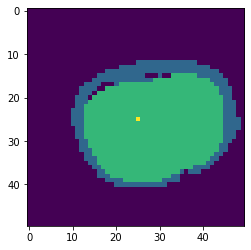

In [53]:
plt.imshow(old[hs:he, ws:we, d])

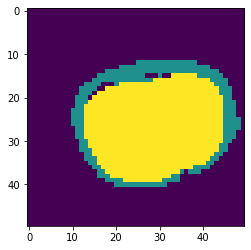

In [54]:
plt.imshow(new[hs:he, ws:we, d])

## Ensamble

In [81]:
SEGNET_PREDICTION_PATH = Path("/sc-scratch/sc-scratch-gbm-radiomics/validation_data/predictions/NewPredictions/TrainerSegNetBase")
UNET_PREDICTION_PATH = Path("/sc-scratch/sc-scratch-gbm-radiomics/validation_data/predictions/NewPredictions/TrainerBratsRegions")

ENSAMBLE_OUTPUT_PATH = Path("/sc-scratch/sc-scratch-gbm-radiomics/validation_data/predictions/NewPredictions/EnsambleSoftmax")

In [143]:
post.segnet_unet_ensamble(SEGNET_PREDICTION_PATH, UNET_PREDICTION_PATH, ENSAMBLE_OUTPUT_PATH, save_softmax=True, save_mask=True)

100%|██████████| 219/219 [01:39<00:00,  2.20it/s]


### Sanity check ensamble

In [241]:
img_id = "00662"

In [242]:
ens_softmax_p = ENSAMBLE_OUTPUT_PATH / f"{img_id}.npz"
ens_img_p = ENSAMBLE_OUTPUT_PATH / f"{img_id}.nii.gz"

unet_softmax_p = UNET_PREDICTION_PATH / f"{img_id}.npz"
unet_img_p = UNET_PREDICTION_PATH / f"{img_id}.nii.gz"

segnet_softmax_p = SEGNET_PREDICTION_PATH / f"{img_id}.npz"
segnet_img_p = SEGNET_PREDICTION_PATH / f"{img_id}.nii.gz"

unet_img = nib.load(unet_img_p).get_fdata()
ens_img = nib.load(ens_img_p).get_fdata()
seg_img = nib.load(segnet_img_p).get_fdata()


In [243]:
print("# Differences SegNet vs. UNet:\t\t", np.sum(seg_img != unet_img))
print("# Differences SegNet vs. Ensemble:\t", np.sum(seg_img != ens_img))
print("# Differences UNet vs. Ensemble:\t", np.sum(unet_img != ens_img))

# Differences SegNet vs. UNet:		 2227
# Differences SegNet vs. Ensemble:	 1780
# Differences UNet vs. Ensemble:	 737


In [244]:
seg_differences = np.where(seg_img != ens_img)
hs = seg_differences[0][0] - 25
he = seg_differences[0][0] + 25

ws = seg_differences[1][0] - 25
we = seg_differences[1][0] + 25

d = seg_differences[2][0]

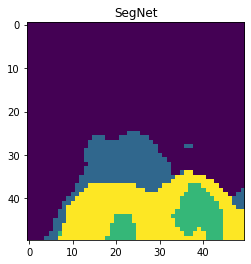

In [245]:
plt.imshow(seg_img[hs:he, ws:we, d])
plt.title("SegNet")
plt.show()

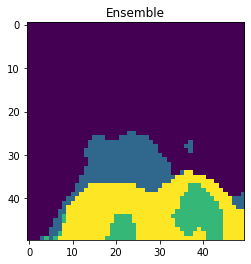

In [246]:
plt.imshow(ens_img[hs:he, ws:we, d])
plt.title("Ensemble")
plt.show()

In [247]:
unet_differences = np.where(unet_img != ens_img)
hs = unet_differences[0][0] - 25
he = unet_differences[0][0] + 25

ws = unet_differences[1][0] - 25
we = unet_differences[1][0] + 25

d = unet_differences[2][0]

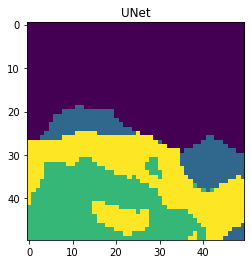

In [248]:
plt.imshow(unet_img[hs:he, ws:we, d])
plt.title("UNet")
plt.show()

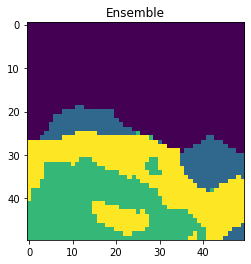

In [249]:
plt.imshow(ens_img[hs:he, ws:we, d])
plt.title("Ensemble")
plt.show()